# SVM Classifiers

In [1]:
from sklearnex import patch_sklearn
patch_sklearn()
import torch
from torchvision.datasets import CIFAR100
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
ROOT_PATH='data'

BATCH_SIZE=1000

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = CIFAR100(root=ROOT_PATH, download=True, train=True, transform=transform)
test_dataset = CIFAR100(root=ROOT_PATH, train=False, transform=transform)

train_data_loader = DataLoader(dataset=train_dataset, num_workers=4, batch_size=BATCH_SIZE, shuffle=True)
test_data_loader = DataLoader(dataset=test_dataset, num_workers=4, batch_size=BATCH_SIZE, shuffle=False)

Files already downloaded and verified


In [5]:
for train_data, train_labels in train_data_loader:
    print(train_data.shape)
    print(train_labels.shape)
    break

for eval_data, eval_labels in test_data_loader:
    print(eval_data.shape)
    print(eval_labels.shape)
    break

torch.Size([1000, 3, 32, 32])
torch.Size([1000])
torch.Size([1000, 3, 32, 32])
torch.Size([1000])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


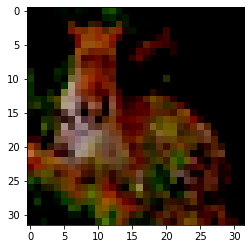

In [6]:
plt.imshow(train_data[100].permute(1,2,0))

The data needs to be flattened from the tensors in order to be used in SVM. The function below loads the data and does this. The training set is loaded in as a train set and validation set, the test set is also loaded in.

In [3]:
def flatten(data_loader):
    images = []
    labels = []

    for img_chunk, label_chunk in data_loader:
        for img in img_chunk:
            img = np.array(img)
            img_flat = img.flatten()
            images.append(img_flat)
        for label in label_chunk:
            labels.append(label)

    images = np.array(images)
    labels = np.array(labels)
    return images, labels

In [4]:
X, y = flatten(train_data_loader)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=41, stratify=y)
X_test, y_test = flatten(test_data_loader)

## Linear SVM

In [7]:
from sklearn.svm import SVC

In [10]:
linear_svm = SVC(C=1.0, kernel='linear', probability=False, random_state=41,
                 decision_function_shape='ovr', tol=0.001, max_iter= -1)

In [11]:
linear_svm.fit(X_train, y_train)
y_pred_train = linear_svm.predict(X_train)
y_pred_val = linear_svm.predict(X_val)
train_accuracy = accuracy_score(y_train, y_pred_train)
val_accuracy = accuracy_score(y_val, y_pred_val)
print('Train acccuracy: ', train_accuracy)
print('Validation accuracy: ', val_accuracy)

Train acccuracy:  0.9996
Validation accuracy:  0.1556


Model is significantly overfitting. We'll now adjust the regularization parameter to address this. Due to the increased time and processing required for cross validations (5x), we'll assess performance via the single validation set.

In [5]:
def fit_svm(X_train, X_val, y_train, y_val, C=1.0, max_iter=-1, decision_function_shape='ovr', tol=0.001, kernel='linear'):
    linear_svm = SVC(C=C, kernel=kernel, probability=False, random_state=41,
                     decision_function_shape=decision_function_shape, tol=tol, max_iter=max_iter)
    linear_svm.fit(X_train, y_train)
    y_pred_train = linear_svm.predict(X_train)
    y_pred_val = linear_svm.predict(X_val)
    train_accuracy = accuracy_score(y_train, y_pred_train)
    val_accuracy = accuracy_score(y_val, y_pred_val)
    print(f'C: {C}, tol: {tol}, max_iter: {max_iter}, {decision_function_shape}')
    print('Train acccuracy: ', train_accuracy)
    print('Validation accuracy: ', val_accuracy, '\n')

In [14]:
for c in [0.1, 0.01, 0.001, 0.0001]:
    fit_svm(X_train, X_val, y_train, y_val, C=c, kernel='linear')

C: 0.1, tol: 0.001, max_iter: -1, ovr
Train acccuracy:  0.930575
Validation accuracy:  0.1645 

C: 0.01, tol: 0.001, max_iter: -1, ovr
Train acccuracy:  0.485675
Validation accuracy:  0.1969 

C: 0.001, tol: 0.001, max_iter: -1, ovr
Train acccuracy:  0.262225
Validation accuracy:  0.1947 

C: 0.0001, tol: 0.001, max_iter: -1, ovr
Train acccuracy:  0.166925
Validation accuracy:  0.1598 



With C = 0.01 as the regularization parameter, we get the best validation accuracy. Below a model with C=0.01 is fit and the accuracy assessed on the test set.

In [8]:
fit_svm(X_train, X_test, y_train, y_test, C=0.01, kernel='linear')

C: 0.01, tol: 0.001, max_iter: -1, ovr
Train acccuracy:  0.48135
Validation accuracy:  0.1936 



### Final Linear SVM Test Accuracy: 19.36%

## Kernel SVM

In order to perform better than the linear SVM model above, we attempt kernel SVM. Below we test a few different values of C and both radial and polynomial kernels.

In [17]:
fit_svm(X_train, X_val, y_train, y_val, C=1, kernel='rbf')

C: 1, tol: 0.001, max_iter: -1, ovr
Train acccuracy:  0.470325
Validation accuracy:  0.2424 



In [18]:
fit_svm(X_train, X_val, y_train, y_val, C=0.1, kernel='rbf')

C: 0.1, tol: 0.001, max_iter: -1, ovr
Train acccuracy:  0.189225
Validation accuracy:  0.1688 



In [20]:
fit_svm(X_train, X_val, y_train, y_val, C=10, kernel='rbf')

C: 10, tol: 0.001, max_iter: -1, ovr
Train acccuracy:  0.89625
Validation accuracy:  0.2643 



In [8]:
fit_svm(X_train, X_val, y_train, y_val, C=100, kernel='rbf')

C: 100, tol: 0.001, max_iter: -1, ovr
Train acccuracy:  0.999825
Validation accuracy:  0.2786 



In [19]:
fit_svm(X_train, X_val, y_train, y_val, C=1, kernel='poly')

C: 1, tol: 0.001, max_iter: -1, ovr
Train acccuracy:  0.513025
Validation accuracy:  0.1855 



In [9]:
fit_svm(X_train, X_val, y_train, y_val, C=10, kernel='poly')

C: 10, tol: 0.001, max_iter: -1, ovr
Train acccuracy:  0.9159
Validation accuracy:  0.2183 



Based on the validation accuracies, the best model is one with a radial kernel and C = 100. Below is this models test accuracy.

In [12]:
best_kernel_svm = SVC(C=100, kernel='rbf', random_state=41, decision_function_shape='ovr')
best_kernel_svm.fit(X, y)
y_pred_test = best_kernel_svm.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
print('Test acccuracy: ', test_accuracy)

Test acccuracy:  0.2906


### Final Kernel SVM Accuracy: 29.06%

## SVM Appendix
Steps for potential further improvement of SVM accuracy

In [13]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
pca = PCA(random_state=41)
scaler = StandardScaler()
X_train_reduced = pca.fit_transform(scaler.fit_transform(X_train))
exp_variance = pca.explained_variance_ratio_

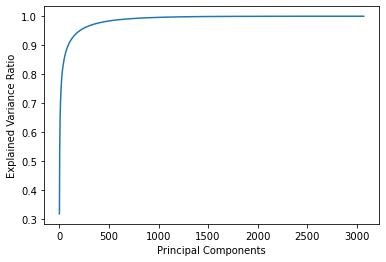

In [14]:
sns.lineplot(x=[x for x in range(0, 3072)], y=np.cumsum(exp_variance))
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.show()

In [16]:
np.cumsum(exp_variance)[250]

0.9593125

In [17]:
X_train_reduced = X_train_reduced[:,:250]
X_val_reduced = pca.transform(X_val)
X_val_reduced = X_val_reduced[:,:250]
fit_svm(X_train_reduced, X_val_reduced, y_train, y_val, C=0.01, kernel='linear')

C: 0.01, tol: 0.001, max_iter: -1, ovr
Train acccuracy:  0.453225
Validation accuracy:  0.1345 



Shown above is a the validation accuracy on the principle components using the best linear model established on the full data. It is similar 0.1345 vs 0.1969. This shows that comparable performance can be achieved on data compressed to 8.14% the original size (95.9% variance preserved). Below code where multiple different models are addressed via cross validation on the decomposed data. If the computational resources allowed, this code would produce the best model based on the data. It performs 5-fold cross validation on linear, radial, 3rd degree polynomial, and 4th degree polynomial kernel models, testing 0.001, 0.01, 0.1, 1, 10, and 100 as values of C. This results in 24 different models, each fit 5 times for a total of 120 fits.

In [17]:
pca = PCA(n_components=250, random_state=41)
scaler = StandardScaler()
X_reduced = pca.fit_transform(scaler.fit_transform(X))
X_test_reduced = pca.transform(X_test)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

svm = SVC()
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'degree': [3, 4]
}

grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, verbose=2, scoring='accuracy')
grid_search.fit(X_reduced, y)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_reduced)
y_pred_test = best_model.predict(X_test_reduced)

In [ ]:
grid_results_df = pd.DataFrame(grid_search.cv_results_)
grid_restuls_df.to_csv('grid_results.csv')
grid_results_df

In [ ]:
train_accuracy = accuracy_score(y, y_pred)
test_accuracy = accuracy_score(y_test, y_pred_test)
print('Train acccuracy: ', train_accuracy)
print('Test accuracy: ', val_accuracy)